In [3]:
import pandas as pd
from WindPy import *

def ema(data, n=12, val_name="close"):
    import numpy as np
    '''
        指数平均数指标 Exponential Moving Average
        Parameters
        ------
          data:pandas.DataFrame
                      通过 get_h_data 取得的数据
          n:int
                      移动平均线时长，时间单位根据data决定
          val_name:string
                      计算哪一列的列名，默认为 close 
        return
        -------
          EMA:numpy.ndarray<numpy.float64>
              指数平均数指标
    '''

    prices = []

    EMA = []

    for index, row in data.iterrows():
        if index == 0:
            past_ema = row[val_name]
            EMA.append(row[val_name])
        else:
            # Y=[2*X+(N-1)*Y’]/(N+1)
            today_ema = (2 * row[val_name] + (n - 1) * past_ema) / (n + 1)
            past_ema = today_ema

            EMA.append(today_ema)

    return np.asarray(EMA)


def macd(data, quick_n=12, slow_n=26, dem_n=9, val_name="close"):
    import numpy as np
    '''
        指数平滑异同平均线(MACD: Moving Average Convergence Divergence)
        Parameters
        ------
          data:pandas.DataFrame
                      通过 get_h_data 取得的
          quick_n:int
                      DIFF差离值中快速移动天数
          slow_n:int
                      DIFF差离值中慢速移动天数
          dem_n:int
                      DEM讯号线的移动天数
          val_name:string
                      计算哪一列的列名，默认为 close 
        return
        -------
          OSC:numpy.ndarray<numpy.float64>
              MACD bar / OSC 差值柱形图 DIFF - DEM
          DIFF:numpy.ndarray<numpy.float64>
              差离值
          DEM:numpy.ndarray<numpy.float64>
              讯号线
    '''

    ema_quick = np.asarray(ema(data, quick_n, val_name))
    ema_slow = np.asarray(ema(data, slow_n, val_name))
    DIFF = ema_quick - ema_slow
    data["diff"] = DIFF
    DEM = ema(data, dem_n, "diff")
    BAR = (DIFF - DEM)*2
    data['dem'] = DEM
    data['bar'] = BAR
    return  DIFF, DEM, BAR


STOCK_CODE='601127.'
df = pd.read_csv(f'./{STOCK_CODE}.csv')

df.columns
df.rename(columns={df.columns[0]:"date"}, inplace=True)
diff, dem ,bar = macd(df)
df
df.to_csv(f"{STOCK_CODE}_macd.csv")
buy_date = []
bar = df[['date', 'diff']]
bar

blue_bar_width = 6  # 绿柱子多少个才考虑买入


def scan_bar(bar, i):
    """
    打印绿柱缩短的第根日期
    返回下一个要遍历的df索引值
    """
    bar_size=bar.index.size

    end_i = i + blue_bar_width
    is_blue_bar_width_enough = (bar.loc[i:end_i, ['diff']] < 0).all()['diff']  # 绿色柱子宽度要足够，过滤掉零零星星不明显的绿柱子
    if is_blue_bar_width_enough:
        # 继续往后去找到全部的绿柱子，找到绿柱最大的索引，打印出来日期
        end_i += 1
        while (bar.loc[end_i:end_i, ['diff']] < 0).all().bool():
            end_i += 1
            if end_i >=bar_size:
                break
        # 开始扫描
        diff, date = bar.loc[i:end_i - 1, ['diff', 'date']].min()  # 负数找最小的（绿柱最长那个）
        print(date)

    else:  # 找到第一个大于等于0的bar点返回，然后从新开始scan
        end_i = i + 1
        while (bar.loc[end_i:end_i, ['diff']] < 0).all().bool():
            end_i += 1
            if end_i >=bar_size:
                break
    #         print(end_i)

    return end_i


def scan_blue_index(df):
    blue_index_range= [] #存放2元tuple， [start:end]

    # 第一步：先把全部blue bar index都放入一个数组
    blue_bar_temp_arr = []
    for i in range(0, df.index.size): #从第一个开始
        diff_val = df.loc[i:i,['bar']]['bar'].values[0]
        if diff_val<0:
            blue_bar_temp_arr.append(i)

    # 第二步：扫描连续的绿柱子做成[start_index, end_index]二元组

    # for i in range(0,len(blue_bar_temp_arr)):
    i=0
    while i < len(blue_bar_temp_arr):
        start_i = i
        end_i = i+1
        while end_i < len(blue_bar_temp_arr) and blue_bar_temp_arr[end_i-1]+1 == blue_bar_temp_arr[end_i]:
            end_i += 1

        blue_index_range.append((blue_bar_temp_arr[i], blue_bar_temp_arr[end_i-1]))
        i = end_i

    return blue_index_range








# for i,r in bar.iterrows():
#     date, diff=r
#     scan_bar(i, bar) # 从i开始向后扫描， 返回扫描终点下一个坐标

i = 0
print(f"index size= {bar.index.size}")
# while i < bar.index.size:
#     # row = bar.loc[i:i+1, bar.columns]
#     # i = scan_bar(bar, i)
#     # print(i)
#     pass

print("===================================")
blue_bar = scan_blue_index(df)
MIN_BLUE_AREA_WIDTH=6

for s, e in blue_bar:
    #print(f"{s}\t{e}")
    if e-s < MIN_BLUE_AREA_WIDTH:
        continue
    else:#把hi值，close取出来
        print(f"{s}\t{e}")
        df2 = df.loc[s:e, ['bar']]
        row_index = df[df.bar==df2.bar.min()].index[0]
        row = df.loc[row_index:row_index, ['date','close','open']]
        buy_row = df.loc[row_index+2:row_index+2, ['date','close','open']]
        print(buy_row['date'].values[0])


    





index size= 625
5	16
2019-01-04 11:00:00
51	58
2019-01-17 12:00:00
60	82
2019-01-23 14:00:00
92	103
2019-01-29 14:00:00
136	142
2019-02-18 11:00:00
158	164
2019-02-22 15:00:00
175	191
2019-03-01 15:00:00
212	218
2019-03-11 11:00:00
223	259
2019-03-14 15:00:00
275	288
2019-03-28 15:00:00
331	347
2019-04-16 14:00:00
360	390
2019-04-26 15:00:00
395	404
2019-05-07 10:00:00
462	471
2019-05-27 11:00:00
481	497
2019-06-03 11:00:00
568	590
2019-06-27 11:00:00
599	607
2019-07-03 15:00:00
615	624
2019-07-09 10:00:00


In [47]:
df

,date,close,high,open,diff,dem,bar
0,2019-01-02 10:00:00,16.66,17.00,17.00,0.000000,0.000000,0.000000
1,2019-01-02 11:00:00,16.65,16.71,16.66,-0.000798,-0.000160,-0.001276
2,2019-01-02 12:00:00,16.62,16.65,16.65,-0.003807,-0.000889,-0.005836
3,2019-01-02 14:00:00,16.70,16.80,16.62,0.000261,-0.000659,0.001840
4,2019-01-02 15:00:00,16.70,16.78,16.70,0.003445,0.000162,0.006566
5,2019-01-03 10:00:00,16.60,16.71,16.70,-0.002077,-0.000286,-0.003582
6,2019-01-03 11:00:00,16.13,16.68,16.58,-0.043873,-0.009003,-0.069739
7,2019-01-03 12:00:00,16.15,16.20,16.15,-0.074523,-0.022107,-0.104832
8,2019-01-03 14:00:00,16.04,16.17,16.16,-0.106463,-0.038978,-0.134968
9,2019-01-03 15:00:00,16.08,16.39,16.04,-0.127082,-0.056599,-0.140966


In [49]:
blue_bar
blue_bar_2 = []
for a,b in blue_bar:
    if b-a <MIN_BLUE_AREA_WIDTH:
        continue
    else:
        blue_bar_2.append((a,b))
        
blue_bar_2

[(5, 16),
 (51, 58),
 (60, 82),
 (92, 103),
 (136, 142),
 (158, 164),
 (175, 191),
 (212, 218),
 (223, 259),
 (275, 288),
 (331, 347),
 (360, 390),
 (395, 404),
 (462, 471),
 (481, 497),
 (568, 590),
 (599, 607),
 (615, 624)]

IndexError: index 0 is out of bounds for axis 0 with size 0

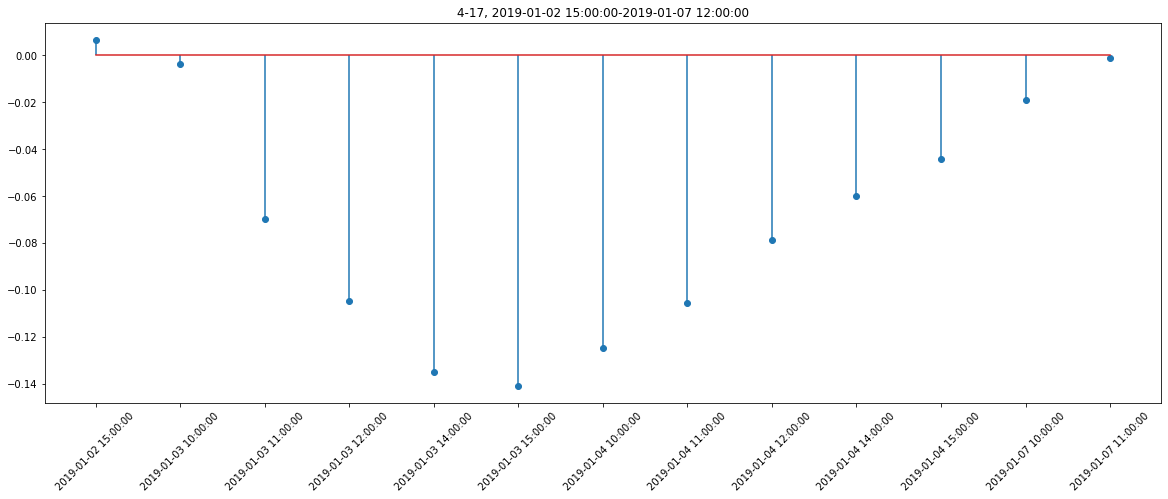

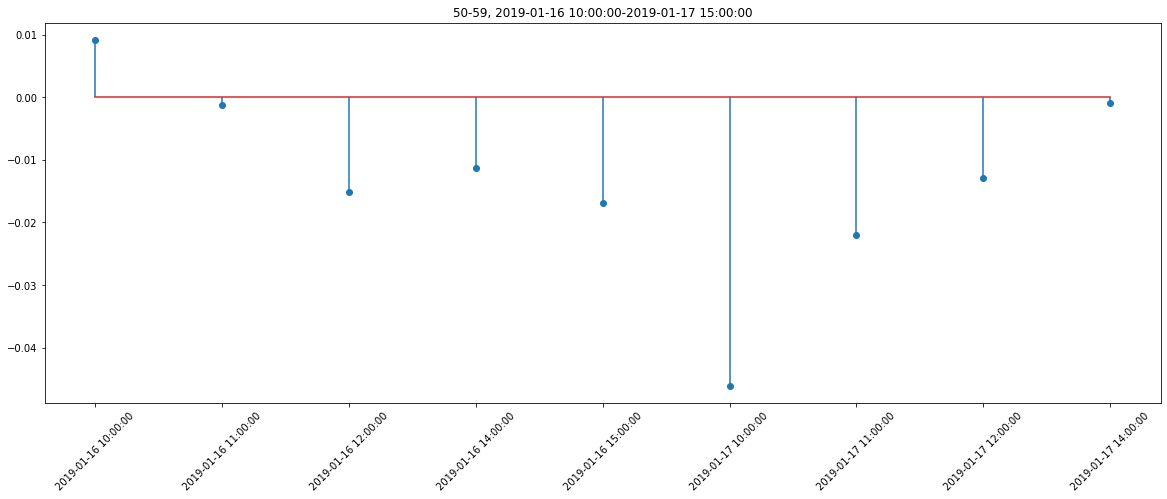

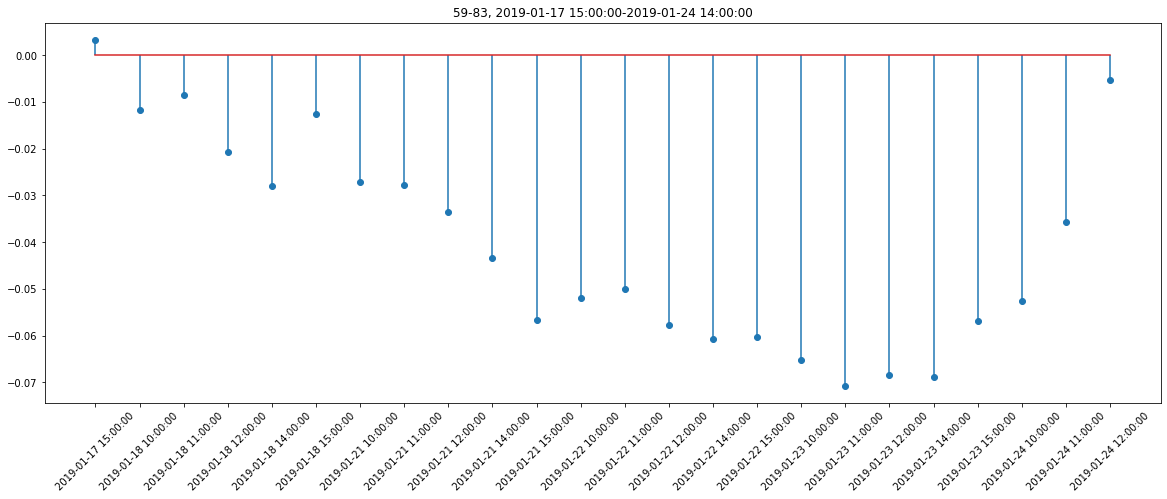

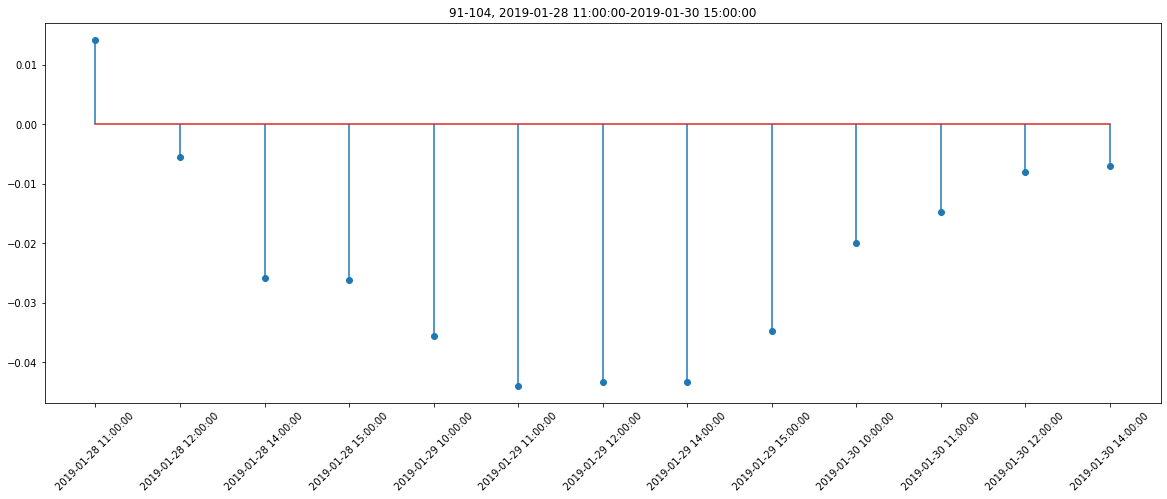

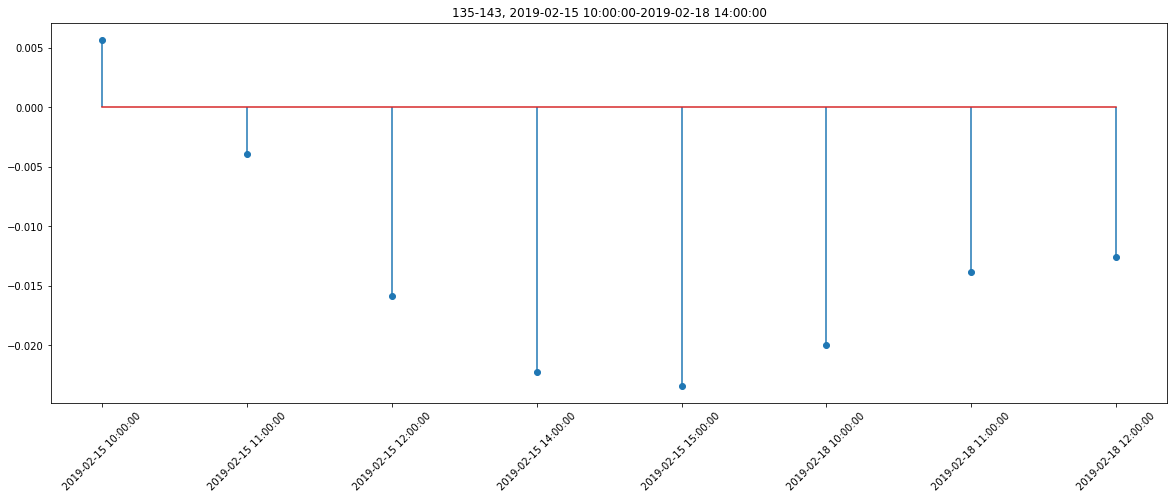

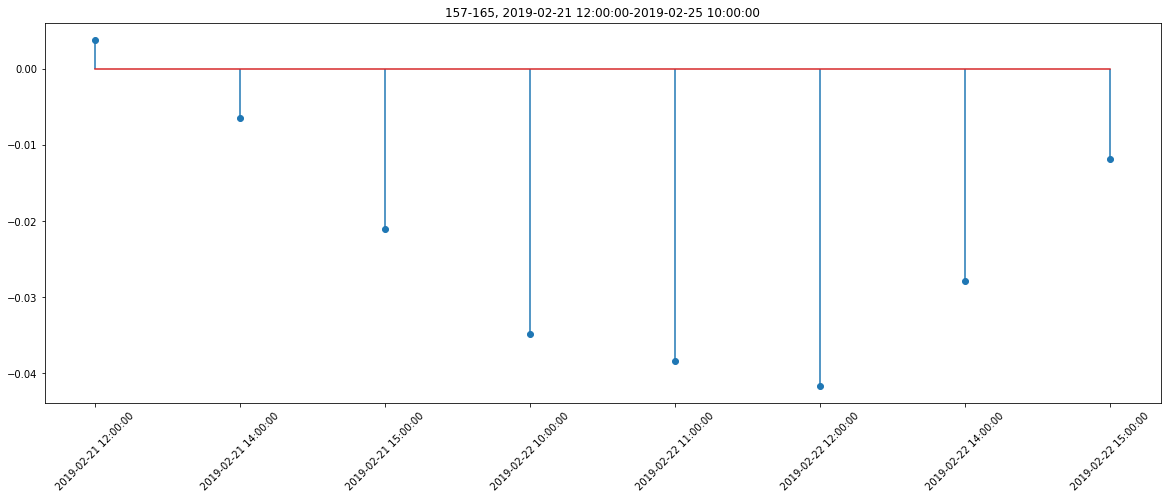

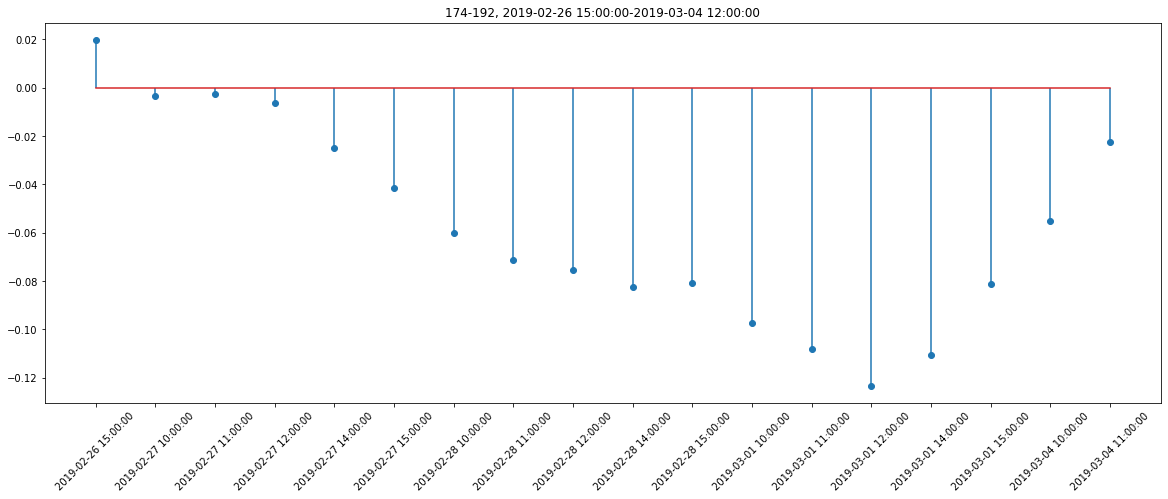

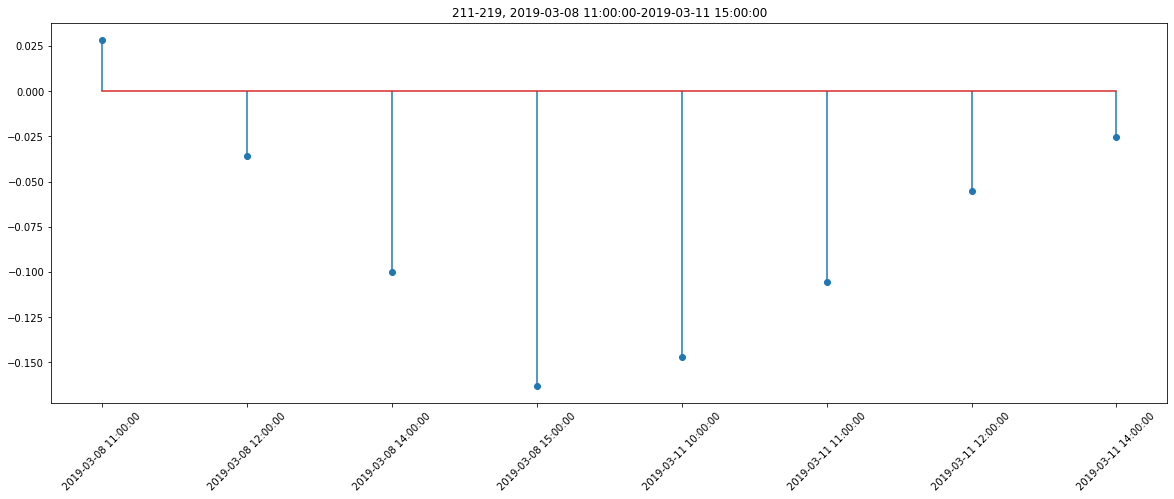

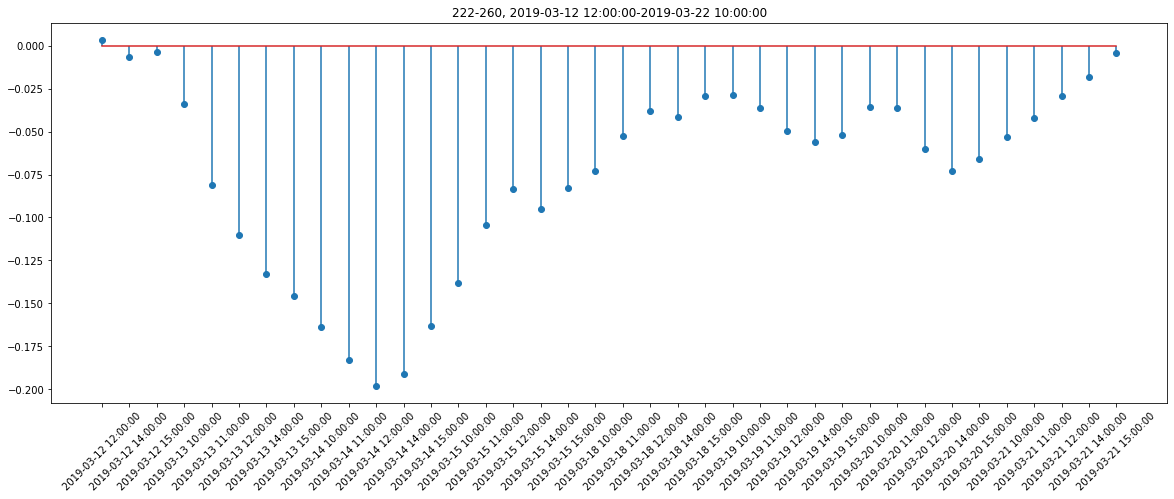

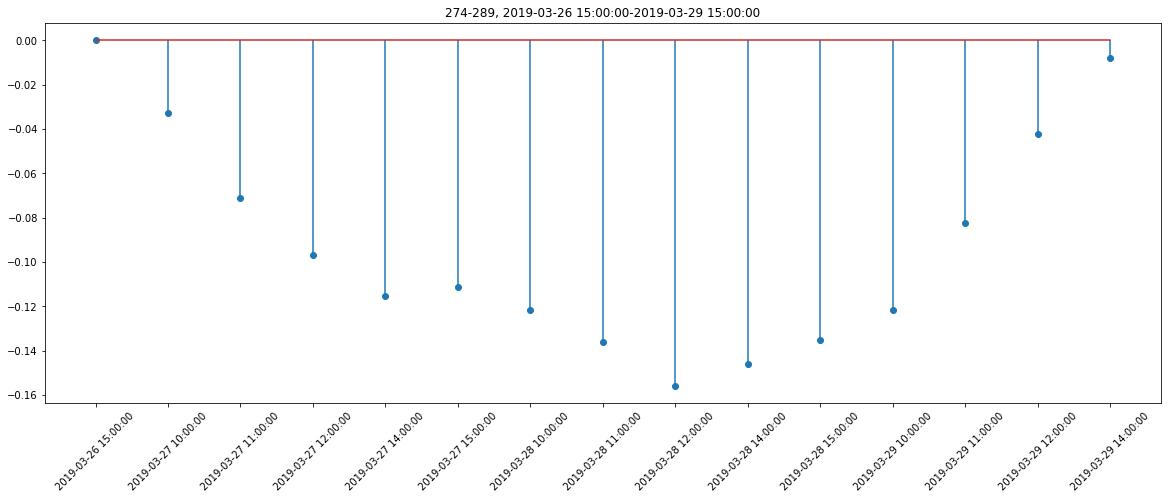

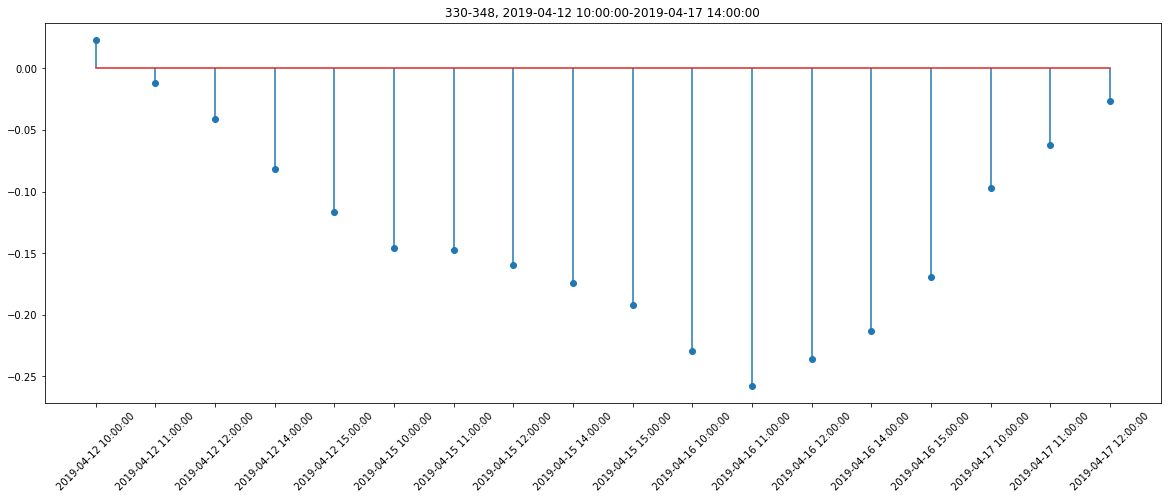

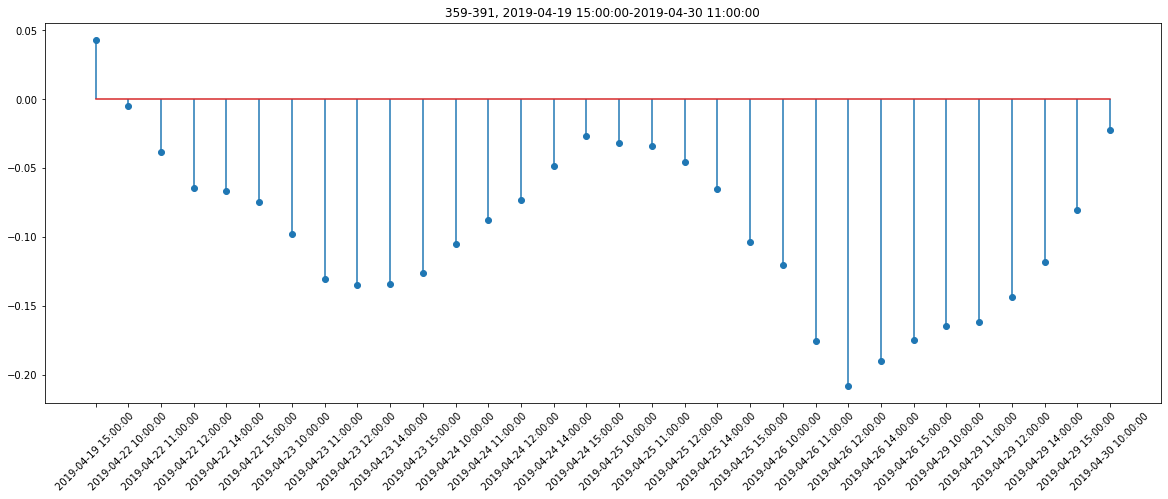

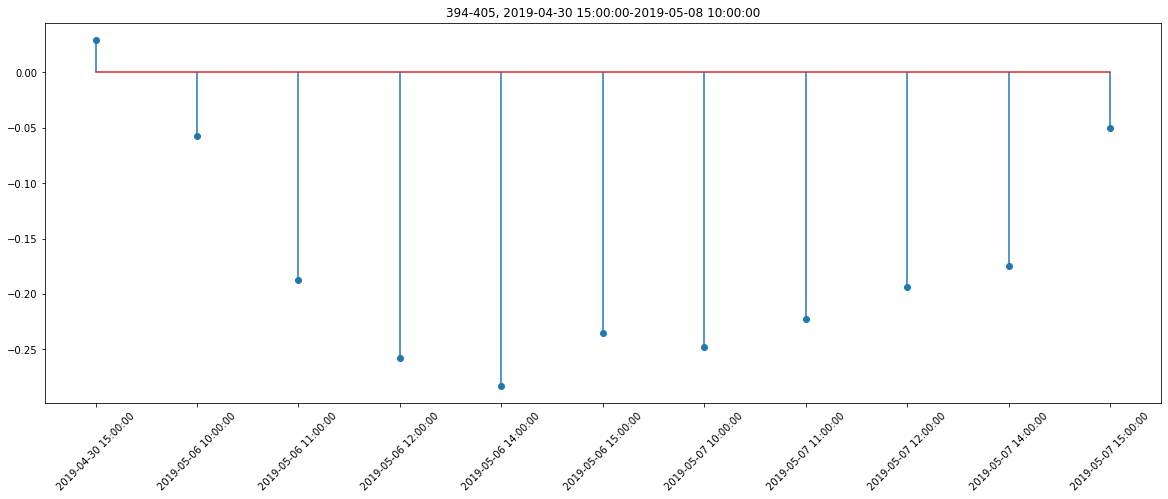

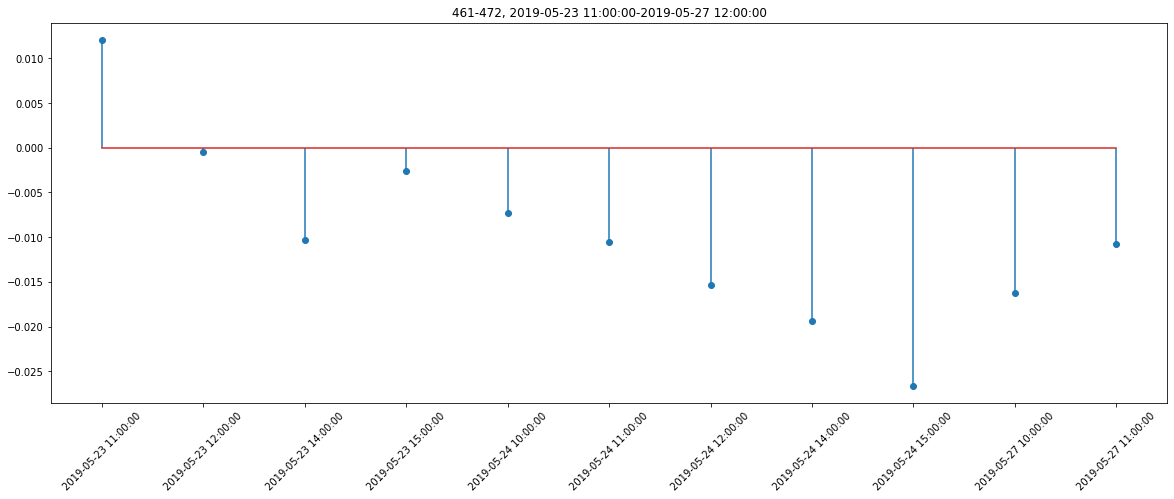

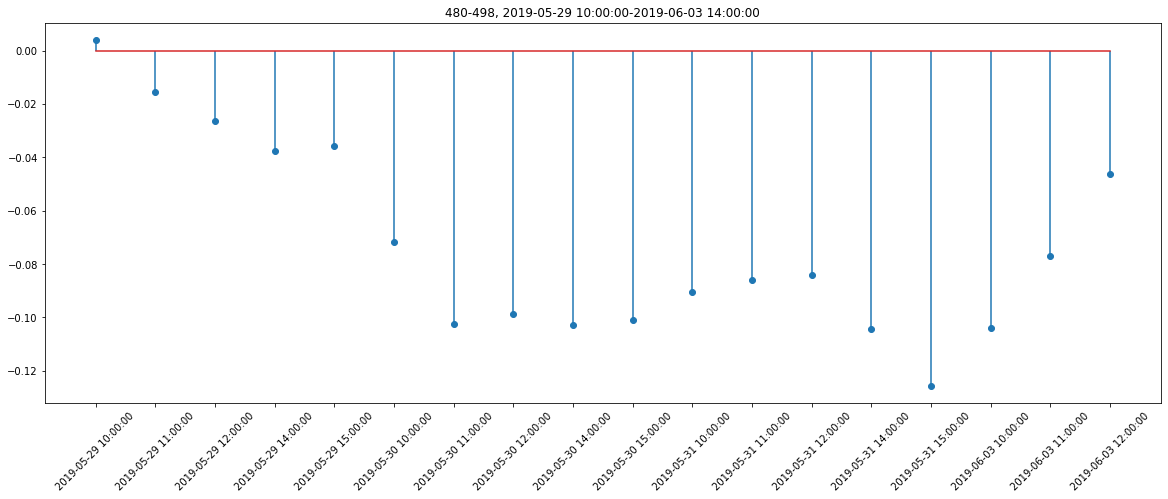

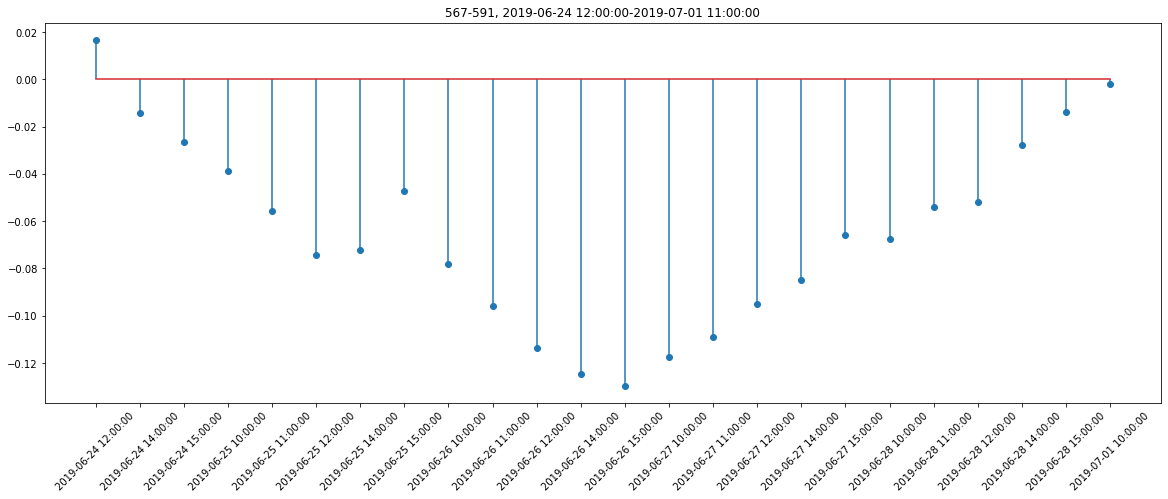

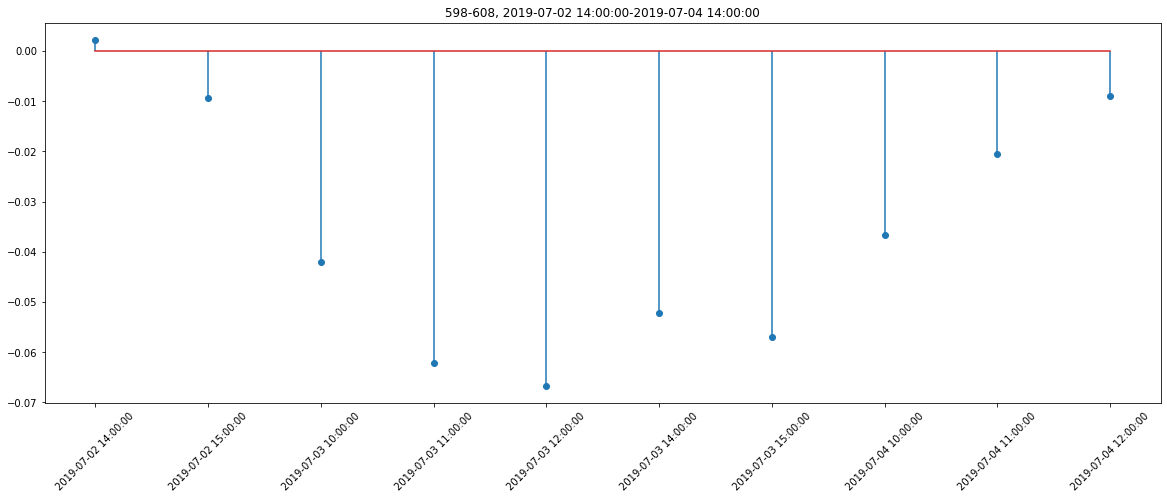

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
# fig, ax = plt.subplots(1,1, figsize=(20, 7))
# ax.stem(df[90:108].date, df[90:108].bar, use_line_collection=True)
# ax.xaxis.set_tick_params(rotation=45)

for s, e in blue_bar_2:
    #print(f"{s}\t{e}")
    start_i = s-1
    if start_i<0:
        start_i = 0
    end_i = e+1
    
    start_dt = df[start_i:start_i+1].date.values[0]
    end_dt = df[end_i:end_i+1].date.values[0]
    fig, ax = plt.subplots(1,1, figsize=(20, 7))
    ax.stem(df[start_i:end_i].date, df[start_i:end_i].bar, use_line_collection=True)
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_title(f"{start_i}-{end_i}, {start_dt}-{end_dt}")
    

In [14]:
df[92:103].date

92     2019-01-28 12:00:00
93     2019-01-28 14:00:00
94     2019-01-28 15:00:00
95     2019-01-29 10:00:00
96     2019-01-29 11:00:00
97     2019-01-29 12:00:00
98     2019-01-29 14:00:00
99     2019-01-29 15:00:00
100    2019-01-30 10:00:00
101    2019-01-30 11:00:00
102    2019-01-30 12:00:00
Name: date, dtype: object

In [ ]:
## 统计一下这几个时间点进入之后，后面16个周期内最高点超过2%的

